# Training a Smoothed Classifier with SmoothMix Example

This notebook shows how to use the ART implementation of SmoothMix training on randomized smoothing classifiers for certified robustness. The goal is to use this training scheme to control the robustness of smoothed classifiers via a *self-mixup*, where it trains on convex combinations of samples along the direction of adversarial perterbation for each input. Training the samples in this way offers an intuitive way to adaptively set a new decision boundary between these samples for better robustness. Full details of this training scheme can be found at https://arxiv.org/pdf/2111.09277.pdf

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms

from art.estimators.certification.smoothmix import PyTorchSmoothMix
from art.utils import compute_accuracy

## Load Dataset
We will load the CIFAR10 dataset. We will also apply the same transformations that the author of the paper used on the dataset (Random Crop, Random Horizontal Flip). Afterward, we will convert the train and test sets to PyTorch tensors

In [2]:
batch_size = 64
train_data = datasets.CIFAR10(
    "./dataset_cache",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
)
test_data = datasets.CIFAR10(
    "./dataset_cache",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=4
)
test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset_cache/cifar-10-python.tar.gz to ./dataset_cache
Files already downloaded and verified


In [3]:
# For train
num_train_samples = 50000

x_train = torch.zeros((num_train_samples, 3, 32, 32), dtype=torch.float32)
y_train = torch.zeros((num_train_samples,), dtype=torch.uint8)

for i,(data,labels) in enumerate(train_loader):
    x_train[(i) * batch_size : (i+1) * batch_size, :, :, :] = data
    y_train[(i) * batch_size : (i+1) * batch_size] = labels

# For test
num_train_samples = 10000

x_test = torch.zeros((num_train_samples, 3, 32, 32), dtype=torch.float32)
y_test = torch.zeros((num_train_samples,), dtype=torch.uint8)

for i,(data,labels) in enumerate(test_loader):
    x_test[(i) * batch_size : (i+1) * batch_size, :, :, :] = data
    y_test[(i) * batch_size : (i+1) * batch_size] = labels

## Define and Train Model
We will use the ResNet-110 model from the original paper as our model to train. We temporarily save a model checkpoint to disk, in case we wish to use this trained model later on

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, layers, width=1, num_classes=10):
        super(ResNet_Cifar, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16 * width, layers[0])
        self.layer2 = self._make_layer(block, 32 * width, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64 * width, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion * width, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet110(**kwargs):
    model = ResNet_Cifar(BasicBlock, [18, 18, 18], width=1, **kwargs)
    return model

In [5]:
model = resnet110()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = nn.CrossEntropyLoss()

# SmoothMix params
nb_epochs = 40
batch_size = 128
mix_step = 1
eta = 5.0
num_noise_vec = 2
warmup = 10
num_steps = 8
mix_step = 0 # 0 for normal, 1 for smoothmix with one-step adv
maxnorm_s = maxnorm = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create and train smoothed classifier, sigma = 0.25, alpha = 0.5
sigma_1 = 0.25
alpha_1 = 0.5

rs_smoothmix_classifier_1 = PyTorchSmoothMix(
    model=model,
    loss=loss,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0., 1.),
    device_type=device,
    alpha=alpha_1,
    scale=sigma_1,
    num_noise_vec=num_noise_vec,
    num_steps=num_steps,
    warmup=warmup,
    eta=eta,
    mix_step=mix_step,
    maxnorm_s=maxnorm_s,
    maxnorm=maxnorm
)

rs_smoothmix_classifier_1.fit(
    x_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size, scheduler=scheduler
)

In [ ]:
# Create and train smoothed classifier, sigma = 0.5, alpha = 1.0
sigma_2 = 0.5
alpha_2 = 1.0

rs_smoothmix_classifier_2 = PyTorchSmoothMix(
    model=model,
    loss=loss,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0., 1.),
    device_type=device,
    alpha=alpha_2,
    scale=sigma_2,
    num_noise_vec=num_noise_vec,
    num_steps=num_steps,
    warmup=warmup,
    eta=eta,
    mix_step=mix_step,
    maxnorm_s=maxnorm_s,
    maxnorm=maxnorm
)

rs_smoothmix_classifier_2.fit(
    x_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size, scheduler=scheduler
)

### Prediction

In [7]:
y_test_encoded = F.one_hot(y_test.to(torch.int64))
# Compute accuracy and coverage of the smoothed models
x_preds_rs_1 = rs_smoothmix_classifier_1.predict(x_test)
x_preds_rs_2 = rs_smoothmix_classifier_2.predict(x_test)

acc_rs_1, cov_rs_1 = compute_accuracy(x_preds_rs_1, y_test_encoded.numpy())
acc_rs_2, cov_rs_2 = compute_accuracy(x_preds_rs_2, y_test_encoded.numpy())

print("\nSmoothed Classifier, sigma=" + str(sigma_1))
print("Accuracy: {}".format(acc_rs_1))
print("Coverage: {}".format(cov_rs_1))

print("\nSmoothed Classifier, sigma=" + str(sigma_2))
print("Accuracy: {}".format(acc_rs_2))
print("Coverage: {}".format(cov_rs_2))

Randomized smoothing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:22<00:00, 38.11it/s]



Smoothed Classifier, sigma=0.25
Accuracy: 0.5892216831892005
Coverage: 0.9482

Smoothed Classifier, sigma=0.5
Accuracy: 0.631
Coverage: 1.0


## Certification of Accuracy and L2-Radius

In [8]:
# Calculate certification accuracy for a given radius
def getCertAcc(radius, pred, y_test):
    rad_list = np.linspace(0, 2.25, 201)
    cert_acc = []
    num_cert = len(radius)
    
    for r in rad_list:
        rad_idx = np.where(radius >= r)[0]
        y_test_subset = y_test[rad_idx]
        cert_acc.append(np.sum(pred[rad_idx] == np.argmax(y_test_subset, axis=1)) / num_cert)
        
    return cert_acc

In [9]:
prediction_1, radius_1 = rs_smoothmix_classifier_1.certify(x_test, n=500)
prediction_2, radius_2 = rs_smoothmix_classifier_2.certify(x_test, n=500)

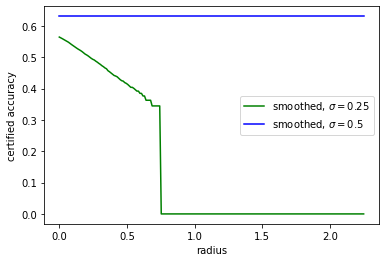

In [10]:
# Plot certification accuracy w.r.t. to radius
rad_list = np.linspace(0, 2.25, 201)
plt.plot(rad_list, getCertAcc(radius_1, prediction_1, y_test_encoded.numpy()), '-', color='green',
         label='smoothed, $\sigma=$' + str(sigma_1))
plt.plot(rad_list, getCertAcc(radius_2, prediction_2, y_test_encoded.numpy()), '-', color='blue',
         label='smoothed, $\sigma=$' + str(sigma_2))
plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.legend()
plt.show()